In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
spy_total_returns = pd.read_excel("spy_data.xlsx", "total returns")
spy_prices = pd.read_excel("spy_data.xlsx", "prices")
spy_total_returns = pd.read_excel("spy_data.xlsx", "total returns")

In [39]:
spy_total_returns

,date,SPY,^IRX
0,1994-01-04,0.004035,0.000122
1,1994-01-05,0.002009,0.000122
2,1994-01-06,0.000000,0.000121
3,1994-01-07,0.006016,0.000119
4,1994-01-10,0.011960,0.000119
...,...,...,...
7675,2024-07-29,0.000588,0.000204
7676,2024-07-30,-0.005066,0.000204
7677,2024-07-31,0.016255,0.000204
7678,2024-08-01,-0.014161,0.000203


In [40]:
# 1.1 Historic VaR
spy_total_returns = spy_total_returns.loc[spy_total_returns.date>='2000-12-29']
spy_excess_returns = spy_total_returns.copy()
spy_excess_returns['SPY_new'] = spy_excess_returns['SPY'] - spy_excess_returns['^IRX']
spy_excess_returns['SPY'] = spy_excess_returns['SPY_new']
spy_excess_returns = spy_excess_returns[['date','SPY']].set_index('date')
spy_excess_returns['SPY_Shifted'] = spy_excess_returns['SPY'].shift(1)

In [41]:
spy_excess_returns

,SPY,SPY_Shifted
date,,
2000-12-29,-0.019157,NaN
2001-01-02,-0.018329,-0.019157
2001-01-03,0.047815,-0.018329
2001-01-04,-0.010972,0.047815
2001-01-05,-0.032840,-0.010972
...,...,...
2024-07-29,0.000384,0.010995
2024-07-30,-0.005270,0.000384
2024-07-31,0.016051,-0.005270


<AxesSubplot:title={'center':'Historic VaR'}, xlabel='Date', ylabel='VaR'>

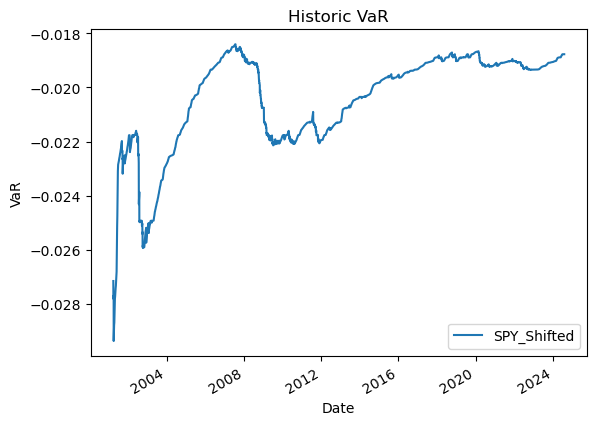

In [42]:
historic_var = spy_excess_returns['SPY_Shifted'].expanding(min_periods = 60).quantile(.05)
historic_var = pd.DataFrame(historic_var)
historic_var.plot(title = 'Historic VaR', ylabel = 'VaR', xlabel = 'Date')

In [51]:
spy_excess_returns['Historic VaR'] = historic_var
frequency = sum(spy_excess_returns['SPY'] < spy_excess_returns['Historic VaR'])/len(spy_excess_returns['Historic VaR'].dropna())
print('5% VaR backtest: {:,.2%}'.format(frequency))

5% VaR backtest: 3.95%


In [53]:
# 1.2 Volatility
n = 252
expanding = np.sqrt((spy_excess_returns['SPY_Shifted']**2).expanding(n).mean())
rolling = np.sqrt((spy_excess_returns['SPY_Shifted']**2).rolling(n).mean())
std = pd.DataFrame({'expanding_window': expanding, 'rolling_window': rolling})

dates = std.dropna().index
theta  = 0.94
num = round(0.2/np.sqrt(n),4)
dates = std.dropna().index
ewma = pd.Series(0, index = dates, name = 'EWMA')
ewma[[0]] = num

for i,ind in enumerate(dates[1:], start=1):
    ewma[[i]] = np.sqrt(theta*(ewma[[i-1]]**2)+(1-theta)*(spy_excess_returns.loc[ind,'SPY']**2))
std_new = pd.merge(std, ewma, how='left', on='date')

<AxesSubplot:title={'center':'Volatility with different methods'}, xlabel='Date', ylabel='Volatility'>

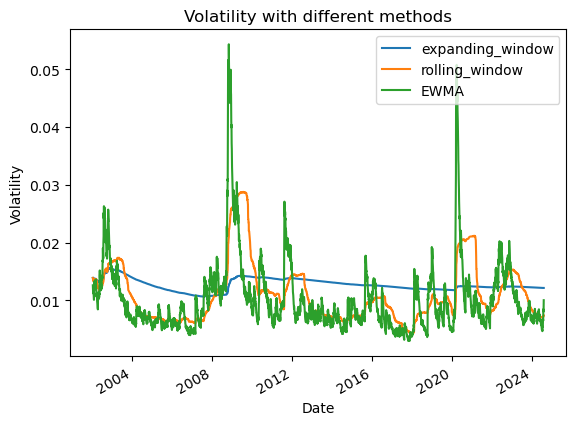

In [96]:
std_new = std_new.dropna()
std_new.plot(title='Volatility with different methods', ylabel = 'Volatility', xlabel = 'Date')

In [125]:
std_new

,expanding_window,rolling_window,EWMA
date,,,
2002-01-07,0.013880,0.013880,0.012600
2002-01-08,0.013860,0.013835,0.012230
2002-01-09,0.013833,0.013787,0.012027
2002-01-10,0.013816,0.013464,0.011709
2002-01-11,0.013792,0.013449,0.011608
...,...,...,...
2024-07-29,0.012144,0.007293,0.008198
2024-07-30,0.012143,0.007280,0.008052
2024-07-31,0.012142,0.007263,0.008741


<AxesSubplot:title={'center':'VaR Estimates'}, xlabel='Date', ylabel='5% VaR'>

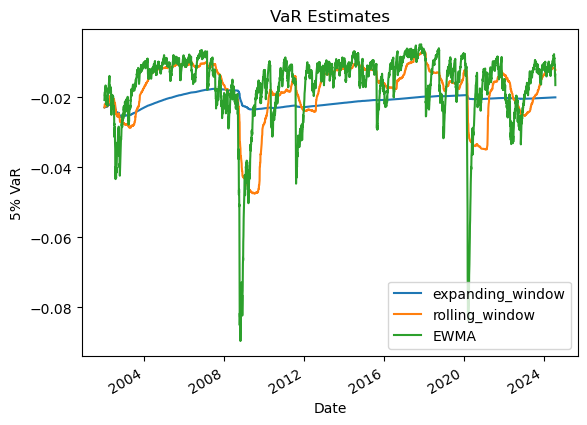

In [98]:
estimate_var = -1.65*std_new
estimate_var.plot(title = 'VaR Estimates', ylabel = '5% VaR', xlabel = 'Date')

In [110]:
compare = pd.merge(spy_excess_returns, estimate_var, how='left', on='date')
for item in compare.columns[3:]:
    frequency = sum(compare['SPY'] < compare[item])/len(compare[item].dropna())
    print(f'5% Estimate VaR {item} backtest: {frequency:,.2%}')

5% Estimate VaR expanding_window backtest: 3.66%
5% Estimate VaR rolling_window backtest: 5.34%
5% Estimate VaR EWMA backtest: 4.97%


<AxesSubplot:title={'center':'Historic CVaR'}, xlabel='Date', ylabel='CVaR'>

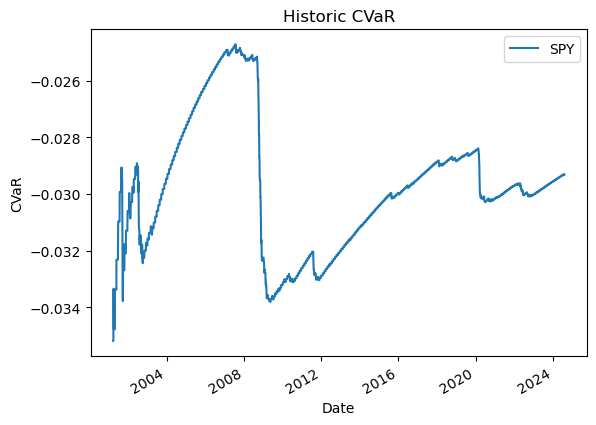

In [115]:
# 1.3 CVaR
# Redo the previous 1.1 and 1.2
historic_cvar = compare['SPY'].expanding(60).apply(lambda x: x[x < x.quantile(.05)].mean())
historic_cvar = pd.DataFrame(historic_cvar)
historic_cvar.plot(title = 'Historic CVaR', ylabel = 'CVaR', xlabel = 'Date')

In [116]:
compare_cvar = spy_excess_returns
compare_cvar['Historic CVaR'] = historic_cvar
frequency = sum(compare_cvar['SPY'] < compare_cvar['Historic CVaR'])/len(compare_cvar['Historic CVaR'].dropna())
print('5% CVaR backtest: {:,.2%}'.format(frequency))

5% CVaR backtest: 1.55%


In [131]:
expanding_cvar = -1.65*np.sqrt((spy_excess_returns['SPY_Shifted']**2).expanding(n).apply(lambda x: x[x < x.quantile(.05)].mean()))
rolling_cvar = -1.65*np.sqrt((spy_excess_returns['SPY_Shifted']**2).rolling(n).apply(lambda x: x[x < x.quantile(.05)].mean()))
estimate_cvar = pd.DataFrame({'expanding_window': expanding_cvar, 'rolling_window': rolling_cvar})
estimate_cvar = pd.merge(estimate_cvar, ewma, how='left', on='date')

<AxesSubplot:title={'center':'CVaR Estimates'}, xlabel='Date', ylabel='5% CVaR'>

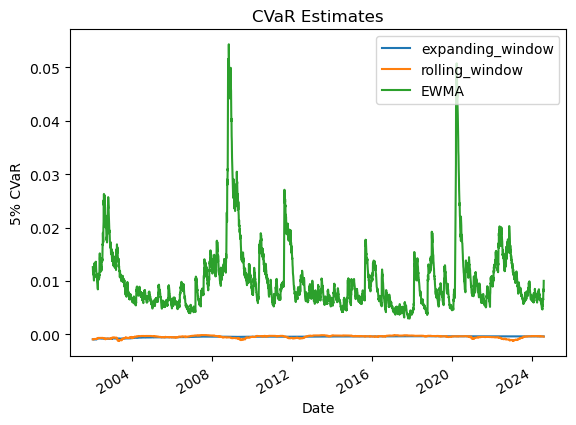

In [132]:
estimate_cvar = estimate_cvar.dropna()
estimate_cvar.plot(title='CVaR Estimates', ylabel = '5% CVaR', xlabel = 'Date')

In [134]:
compare = pd.merge(spy_excess_returns, estimate_cvar, how='left', on='date')
for item in compare.columns[4:]:
    frequency = sum(compare['SPY'] < compare[item])/len(compare[item].dropna())
    print(f'5% Estimate VaR {item} backtest: {frequency:,.2%}')

5% Estimate VaR Historic CVaR backtest: 1.55%
5% Estimate VaR expanding_window backtest: 43.01%
5% Estimate VaR rolling_window backtest: 42.99%
5% Estimate VaR EWMA backtest: 84.09%


In [ ]:
expanding = np.sqrt((spy_excess_returns['SPY_Shifted']**2).expanding(n).mean())
rolling = np.sqrt((spy_excess_returns['SPY_Shifted']**2).rolling(n).mean())
std = pd.DataFrame({'expanding_window': expanding, 'rolling_window': rolling})

dates = std.dropna().index
theta  = 0.94
num = round(0.2/np.sqrt(n),4)
dates = std.dropna().index
ewma = pd.Series(0, index = dates, name = 'EWMA')
ewma[[0]] = num

for i,ind in enumerate(dates[1:], start=1):
    ewma[[i]] = np.sqrt(theta*(ewma[[i-1]]**2)+(1-theta)*(spy_excess_returns.loc[ind,'SPY']**2))
std_new = pd.merge(std, ewma, how='left', on='date')